<a href="https://colab.research.google.com/github/surabhi13gupta/MP/blob/main/Module%205/MP2/Surabhi_M5_NB_MiniProject_02_Fare_Amount_Prediction_Using_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini Project: Implementation of Linear Regression on a Large Dataset Using Dask Library

## Learning Objectives

At the end of the mini-project, you will be able to :

- understand how dask handles large dataset over pandas dataframe
- perform exploratory data analysis on a large dataset (2 Million rows) using dask
- implement linear regression model using dask library and make predictions


## Problem Statement

 Predict the taxi fare amount in New York city using Dask-ML.

## Information

### Dask
[Dask](https://dask.pydata.org/en/latest/) is an open source project that gives abstractions over NumPy Arrays, Pandas Dataframes and regular lists, allowing you to run operations on them in parallel, using multicore processing.

We can summarize the basics of Dask as follows:

* processes data that doesn’t fit into memory by breaking it into blocks and specifying task chains

* parallelizes execution of tasks across cores and even nodes of a cluster

* moves computation to the data rather than the other way around, to minimize communication overhead

### Dataset

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. Its variables are as follows:
![Dataset](https://cdn.exec.talentsprint.com/static/cds/NYC_Taxi_data_description_image.png)




Note that the features the ' Dask_MP_dataset.csv' file that is provided for this miniproject varies slightly in terms of included features, as compared to the original dataset described above. Please proceed with the provided csv file.

## Grading = 10 Points

In [2]:
#@title Install Dask dependencies and restart runtime
!pip -qq install dask-ml
!pip -qq install dask
!pip -qq install dask[complete]
!pip install --upgrade --force-reinstall dask distributed
!pip -qq install mimesis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 20.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rapids-dask-dependency 25.2.0 requires dask==2024.12.1, but you have dask 2025.5.1 which is incompatible.
rapids-dask-dependency 25.2.0 requires distributed==2024.12.1, but you have distributed 2025.5.1 which is incompatible.
dask-expr 1.1.21 requires dask==2024.12.1, but you have dask 2025.5.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00
  Using cached dask-2025.5.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached distributed-2025.5.1-py3-none-any.w

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 37.9 MB/s eta 0:00:00


#### Importing Necessary Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import dask
import dask.dataframe as dd
import dask.array as da
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_squared_error, r2_score
import time as time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dask.distributed import Client, progress
client = Client()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-x1mbmdv5', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-8v7pzdg3', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-h6_9mcpo', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-zoy6c4eh', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-y73o5ph4', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-cgepznp5', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-zbld3rn8', purging
INFO:dist

In [2]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv

--2025-05-24 09:29:16--  https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231900522 (221M) [application/octet-stream]
Saving to: ‘Dask_MP_dataset.csv.1’

Dask_MP_dataset.csv 100%[===================>] 221.16M  10.2MB/s    in 25s     

2025-05-24 09:29:42 (8.96 MB/s) - ‘Dask_MP_dataset.csv.1’ saved [231900522/231900522]



## Utility functions

In [2]:
import psutil
print(f"Total logical CPUs available on the system: {psutil.cpu_count()}")
print(f"Total logical CPUs available on the system: {psutil.cpu_count(logical=False)}")

Total logical CPUs available on the system: 2
Total logical CPUs available on the system: 1


In [3]:
def print_dask_workers():
    print(f"Number of workers: {len(client.scheduler_info()['workers'])}")
    print(f"Number of cores (threads per worker * number of workers): {sum(w['nthreads'] for w in client.scheduler_info()['workers'].values())}")

In [4]:
print_dask_workers()

Number of workers: 2
Number of cores (threads per worker * number of workers): 2


In [5]:
# Function to get current memory usage
def memory_in_mb():
    process = psutil.Process()
    mem = process.memory_info().rss  # Get memory usage in bytes
    mb_mem =  mem / (1024 ** 2)  # Convert to MB
    return mb_mem

# Function to get current CPU usage
def cpu_usage_percent():
    return psutil.cpu_percent(interval=1)

In [6]:
print(f"Initial Memory Consumption: {memory_in_mb()} MB")

Initial Memory Consumption: 397.328125 MB


In [7]:
#Increase the number of workers and threads per workers for better distribution

client = Client(n_workers=4, threads_per_worker=2)
print(client)
print_dask_workers()

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45485
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:46509/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36833'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34119'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44651'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33649'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:34777 name: 3
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:34777
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:51190
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:45347 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45347
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:5

<Client: 'tcp://127.0.0.1:45485' processes=4 threads=8, memory=12.67 GiB>
Number of workers: 4
Number of cores (threads per worker * number of workers): 8


#### Exercise 1: Read the dataset using dask library and compare the time of execution with pandas library. (1 Point)

**Hint:** pass `dtype` for passenger_count as `int64`

In [8]:
metrics_df = pd.DataFrame()
metrics_df["Action"] = []
metrics_df["Pandas"] = []
metrics_df["Dask"] = []
metrics_df

,Action,Pandas,Dask


In [9]:
%%time
# YOUR CODE HERE
start_time = time.time()
dd_data = dd.read_csv("Dask_MP_dataset.csv")
dd_data.compute()
dask_read = time.time() - start_time

CPU times: user 2.08 s, sys: 1.37 s, total: 3.45 s
Wall time: 19.1 s


In [10]:
dd_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [11]:
dd_data.dtypes

,0
Unnamed: 0,int64
key,string[pyarrow]
fare_amount,float64
pickup_datetime,string[pyarrow]
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64


#### Use pandas to read the dataset and compare the time taken

In [12]:
%%time
# YOUR CODE HERE
start_time = time.time()
dd_pandas = pd.read_csv("Dask_MP_dataset.csv")
pandas_read = time.time() - start_time
dd_pandas.head()

CPU times: user 5.57 s, sys: 602 ms, total: 6.17 s
Wall time: 5.83 s


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [13]:
dd_pandas.dtypes

,0
Unnamed: 0,int64
key,object
fare_amount,float64
pickup_datetime,object
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64


In [14]:
metrics_df.loc[len(metrics_df.index)] = ['CSV Read Time', pandas_read, dask_read]
metrics_df

,Action,Pandas,Dask
0,CSV Read Time,5.833181,19.040558


In [15]:
print(f"Memory Consumption After read: {memory_in_mb()} MB")

Memory Consumption After read: 1182.56640625 MB


### Data Analysis



#### Exercise 2: Drop the unnecessary columns. Also drop the duplicate rows and the rows having null values. (1 Point)

**Hint:** Drop those columns which are not useful in EDA as well as model implementation

In [16]:
def data_info(data):
    print("=====================================")
    print("Data types: ")
    print(data.dtypes)
    print("=====================================")
    print("Check for null values")
    print(data.isna().sum().compute())
    print("=====================================")
    print("Statistical information:")
    print(data.describe().compute())
    print("=====================================")

In [17]:
data_info(dd_data)

Data types: 
Unnamed: 0                     int64
key                  string[pyarrow]
fare_amount                  float64
pickup_datetime      string[pyarrow]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
dtype: object
Check for null values
Unnamed: 0            0
key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64
Statistical information:
         Unnamed: 0   fare_amount  pickup_longitude  pickup_latitude  \
count  2.000000e+06  2.000000e+06      2.000000e+06     2.000000e+06   
mean   9.999995e+05  1.134779e+01     -7.252321e+01     3.992963e+01   
std    5.773504e+05  9.852883e+00      1.286804e+01     7.983352e+00   
min    0.000000e+00 -6.200000e+01     -3.377681e+03    -3.458665e+03   
25% 

### Inference:
- there are 14 rows having null value for dropoff_longitude and dropoff_latitude contributes only 0.0007% and hence, can be dropped off
- Unnamed and key are unnecessary columns and can be dropped off. key is same as pickup_datetime and unnamed is same as index of dataframe
- Minimum fare is negative which is not possible - analysis it

In [18]:
print("Analysis of negative fare amount")
dd_data[dd_data["fare_amount"]<0].compute()

Analysis of negative fare amount


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,2039,2010-03-09 23:37:10.0000005,-2.9,2010-03-09 23:37:10 UTC,-73.789450,40.643498,-73.788665,40.641952,1
2486,2486,2015-03-22 05:14:27.0000001,-2.5,2015-03-22 05:14:27 UTC,-74.000031,40.720631,-73.999809,40.720539,1
13032,13032,2013-08-30 08:57:10.0000002,-3.0,2013-08-30 08:57:10 UTC,-73.995062,40.740755,-73.995885,40.741357,4
28839,28839,2013-08-11 13:39:10.0000001,-2.5,2013-08-11 13:39:10 UTC,-73.785260,40.648442,0.000000,0.000000,1
36722,36722,2015-04-30 15:19:45.0000003,-2.5,2015-04-30 15:19:45 UTC,-73.952187,40.790112,-73.950043,40.792839,1
...,...,...,...,...,...,...,...,...,...
377722,1714213,2010-02-16 16:03:10.0000001,-6.1,2010-02-16 16:03:10 UTC,-73.962520,40.778692,-73.971705,40.766107,1
385781,1722272,2015-06-08 14:42:50.0000003,-52.0,2015-06-08 14:42:50 UTC,-73.992683,40.757755,-73.992958,40.757812,1
542501,1878992,2013-08-16 08:20:10.0000004,-5.5,2013-08-16 08:20:10 UTC,-73.989182,40.774740,-73.983615,40.767930,1
553112,1889603,2015-03-09 18:19:54.0000001,-2.5,2015-03-09 18:19:54 UTC,0.000000,0.000000,0.000000,0.000000,5


In [19]:
start_time = time.time()
print("Drop rows having negative fare amount")
print("=====================================\n")
print("Resulting dataframe type before removing rows: ", type(dd_data))
dd_data = dd_data[dd_data['fare_amount'] >= 0].compute()
dd_data = dd.from_pandas(dd_data)
print("Resulting dataframe type after removing rows: ", type(dd_data))
metrics_df.loc[len(metrics_df.index)] = ['After dropping rows with negative fare', np.nan, time.time()-start_time]
dd_data.head()

Drop rows having negative fare amount

Resulting dataframe type before removing rows:  <class 'dask.dataframe.dask_expr._collection.DataFrame'>
Resulting dataframe type after removing rows:  <class 'dask.dataframe.dask_expr._collection.DataFrame'>


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
0,1336491,2014-09-21 10:02:20.0000002,91.0,2014-09-21 10:02:20 UTC,-74.009455,40.724818,-73.965932,40.638384,1
0,670185,2009-05-29 18:58:00.000000270,7.7,2009-05-29 18:58:00 UTC,-74.006425,40.744747,-73.981225,40.769387,3
1,670186,2010-08-23 14:09:16.0000004,4.1,2010-08-23 14:09:16 UTC,-73.982811,40.766794,-73.982048,40.774986,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1


In [20]:
""" Drop unnecessary columns """
# YOUR CODE HERE
start_time = time.time()
dd_df = dd_data.drop(columns=['key', 'Unnamed: 0'], axis=1)
dd_df = dd_df.compute()
print("Resulting dataframe type after dropping columns: ", type(dd_df))
dd_df_dask = dd.from_pandas(dd_df)
print("Resulting dataframe type after converting back to dask:", type(dd_df_dask))
dask_time = time.time() - start_time
dd_df_dask.head()

Resulting dataframe type after dropping columns:  <class 'pandas.core.frame.DataFrame'>
Resulting dataframe type after converting back to dask: <class 'dask.dataframe.dask_expr._collection.DataFrame'>


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
0,91.0,2014-09-21 10:02:20 UTC,-74.009455,40.724818,-73.965932,40.638384,1
0,7.7,2009-05-29 18:58:00 UTC,-74.006425,40.744747,-73.981225,40.769387,3
1,4.1,2010-08-23 14:09:16 UTC,-73.982811,40.766794,-73.982048,40.774986,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1


In [21]:
%%time
start_time = time.time()
print("Drop duplicate rows in PANDAS DATAFRAME")
print("-------------------------------------------\n")

orig_count = len(dd_df)
print("Number of rows before dropping of duplicate rows: ", len(dd_df))
print("-------------------------------------------\n")
print("Resulting dataframe type before droppping duplicates: ", type(dd_df))
print("-------------------------------------------\n")
dd_df = dd_df.drop_duplicates()
print("Resulting dataframe type after droppping duplicates: ", type(dd_df))
print("-------------------------------------------\n")
print("Number of rows after dropping of duplicate rows: ", len(dd_df))
print("-------------------------------------------\n")
print("Number of duplicate rows: ", orig_count - len(dd_df))
print("-------------------------------------------\n")
pandas_time = time.time() - start_time
dd_df.head()

Drop duplicate rows in PANDAS DATAFRAME
-------------------------------------------

Number of rows before dropping of duplicate rows:  1999923
-------------------------------------------

Resulting dataframe type before droppping duplicates:  <class 'pandas.core.frame.DataFrame'>
-------------------------------------------

Resulting dataframe type after droppping duplicates:  <class 'pandas.core.frame.DataFrame'>
-------------------------------------------

Number of rows after dropping of duplicate rows:  1999920
-------------------------------------------

Number of duplicate rows:  3
-------------------------------------------

CPU times: user 2.49 s, sys: 432 ms, total: 2.92 s
Wall time: 2.67 s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
0,91.0,2014-09-21 10:02:20 UTC,-74.009455,40.724818,-73.965932,40.638384,1
0,7.7,2009-05-29 18:58:00 UTC,-74.006425,40.744747,-73.981225,40.769387,3
1,4.1,2010-08-23 14:09:16 UTC,-73.982811,40.766794,-73.982048,40.774986,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1


In [22]:
%%time
start_time = time.time()
print("Drop duplicate rows in DASK DATAFRAME")
print("-------------------------------------------\n")

orig_count = len(dd_df_dask)
print("Number of rows before dropping of duplicate rows: ", len(dd_df_dask))
print("-------------------------------------------\n")
print("Resulting dataframe type before droppping duplicates: ", type(dd_df_dask))
print("-------------------------------------------\n")
dd_df_dask = dd_df_dask.drop_duplicates()
print("Resulting dataframe type after droppping duplicates: ", type(dd_df_dask))
print("-------------------------------------------\n")
print("Number of rows after dropping of duplicate rows: ", len(dd_df_dask))
print("-------------------------------------------\n")
print("Number of duplicate rows: ", orig_count - len(dd_df_dask))
print("-------------------------------------------\n")
dask_time = time.time() - start_time
dd_df_dask.head()

Drop duplicate rows in DASK DATAFRAME
-------------------------------------------

Number of rows before dropping of duplicate rows:  1999923
-------------------------------------------

Resulting dataframe type before droppping duplicates:  <class 'dask.dataframe.dask_expr._collection.DataFrame'>
-------------------------------------------

Resulting dataframe type after droppping duplicates:  <class 'dask.dataframe.dask_expr._collection.DataFrame'>
-------------------------------------------



Number of rows after dropping of duplicate rows:  1999920
-------------------------------------------



Number of duplicate rows:  3
-------------------------------------------



CPU times: user 6.25 s, sys: 1.97 s, total: 8.23 s
Wall time: 54.2 s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
0,91.0,2014-09-21 10:02:20 UTC,-74.009455,40.724818,-73.965932,40.638384,1
0,7.7,2009-05-29 18:58:00 UTC,-74.006425,40.744747,-73.981225,40.769387,3
1,4.1,2010-08-23 14:09:16 UTC,-73.982811,40.766794,-73.982048,40.774986,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1


In [23]:
metrics_df.loc[len(metrics_df.index)] = ['Dropping Duplicate Rows', pandas_time, dask_time]
metrics_df

,Action,Pandas,Dask
0,CSV Read Time,5.833181,19.040558
1,After dropping rows with negative fare,NaN,9.284649
2,Dropping Duplicate Rows,2.666148,38.527332


In [24]:
%%time
""" drop NA rows """
start_time = time.time()
print("Drop NA rows in PANDAS DATAFRAME")
print("-------------------------------------------\n")

orig_count = len(dd_df)
print("Number of rows before dropping of null rows: ", len(dd_df))
print("-------------------------------------------\n")
print("Resulting dataframe type before dropping null rows: ", type(dd_df))
print("-------------------------------------------\n")
dd_df = dd_df.dropna()
print("Resulting dataframe type after dropping null rows: ", type(dd_df))
print("-------------------------------------------\n")
print("Number of rows after dropping null rows: ", len(dd_df))
print("-------------------------------------------\n")
print("Number of rows having null values: ", orig_count - len(dd_df))
print("-------------------------------------------\n")
pandas_time = time.time() - start_time
dd_df.head()

Drop NA rows in PANDAS DATAFRAME
-------------------------------------------

Number of rows before dropping of null rows:  1999920
-------------------------------------------

Resulting dataframe type before dropping null rows:  <class 'pandas.core.frame.DataFrame'>
-------------------------------------------

Resulting dataframe type after dropping null rows:  <class 'pandas.core.frame.DataFrame'>
-------------------------------------------

Number of rows after dropping null rows:  1999906
-------------------------------------------

Number of rows having null values:  14
-------------------------------------------

CPU times: user 122 ms, sys: 39.1 ms, total: 161 ms
Wall time: 151 ms


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
0,91.0,2014-09-21 10:02:20 UTC,-74.009455,40.724818,-73.965932,40.638384,1
0,7.7,2009-05-29 18:58:00 UTC,-74.006425,40.744747,-73.981225,40.769387,3
1,4.1,2010-08-23 14:09:16 UTC,-73.982811,40.766794,-73.982048,40.774986,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1


In [25]:
%%time
start_time = time.time()
""" drop NA rows """
print("Drop NA rows in DASK DATAFRAME")
print("-------------------------------------------\n")

orig_count = len(dd_df_dask)
print("Number of rows before dropping of null rows: ", len(dd_df_dask))
print("-------------------------------------------\n")
print("Resulting dataframe type before dropping null rows: ", type(dd_df_dask))
print("-------------------------------------------\n")
dd_df_dask = dd_df_dask.dropna()
print("Resulting dataframe type after dropping null rows: ", type(dd_df_dask))
print("-------------------------------------------\n")
print("Number of rows after dropping null rows: ", len(dd_df_dask))
print("-------------------------------------------\n")
print("Number of rows having null values: ", orig_count - len(dd_df_dask))
print("-------------------------------------------\n")
dask_time = time.time() - start_time
dd_df_dask.head()

Drop NA rows in DASK DATAFRAME
-------------------------------------------



Number of rows before dropping of null rows:  1999920
-------------------------------------------

Resulting dataframe type before dropping null rows:  <class 'dask.dataframe.dask_expr._collection.DataFrame'>
-------------------------------------------

Resulting dataframe type after dropping null rows:  <class 'dask.dataframe.dask_expr._collection.DataFrame'>
-------------------------------------------



Number of rows after dropping null rows:  1999906
-------------------------------------------



Number of rows having null values:  14
-------------------------------------------



CPU times: user 9.18 s, sys: 3.23 s, total: 12.4 s
Wall time: 1min 20s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
0,91.0,2014-09-21 10:02:20 UTC,-74.009455,40.724818,-73.965932,40.638384,1
0,7.7,2009-05-29 18:58:00 UTC,-74.006425,40.744747,-73.981225,40.769387,3
1,4.1,2010-08-23 14:09:16 UTC,-73.982811,40.766794,-73.982048,40.774986,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1


In [26]:
metrics_df.loc[len(metrics_df.index)] = ['Dropping Null/NA values', pandas_time, dask_time]
metrics_df

,Action,Pandas,Dask
0,CSV Read Time,5.833181,19.040558
1,After dropping rows with negative fare,NaN,9.284649
2,Dropping Duplicate Rows,2.666148,38.527332
3,Dropping Null/NA values,0.150854,65.505908



##Inference from Excerice 2

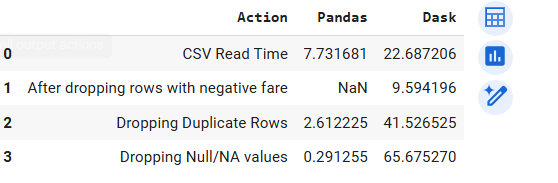

#### Exercise 3: Visualize the target variable, i.e., `fare_amount` to study the fare distribution, using a histogram density plot. Analyze the fare_amount distribution, try to visualize it for a range of [0, 60]. (1 Point)

**Hint:** [sns.hisplot()](https://stackoverflow.com/questions/51027636/seaborn-histogram-with-bigdata/51027895) and use `.between` to plot the graph for given range


In [27]:
print("Unique Fare amount: ", dd_df["fare_amount"].unique())
print("Total unique fare amount: ", len(dd_df["fare_amount"].unique()))

Unique Fare amount:  [  4.5   91.     7.7  ... 135.58 145.25  38.99]
Total unique fare amount:  2801


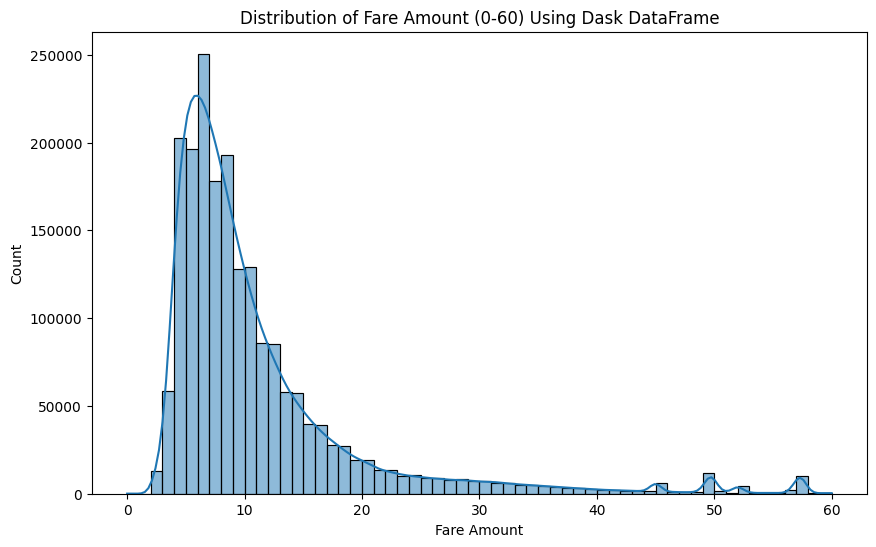

In [29]:
""" explore and plot the density plot of fare_amount """
# YOUR CODE HERE
dd_df_fare_limited = dd_df_dask[dd_df_dask["fare_amount"].between(0,60)].compute()
plt.figure(figsize=(10,6))
sns.histplot(dd_df_fare_limited, x="fare_amount", bins=60, kde=True)
plt.title('Distribution of Fare Amount (0-60) Using Dask DataFrame')
plt.xlabel("Fare Amount")
plt.ylabel("Count")
plt.show()

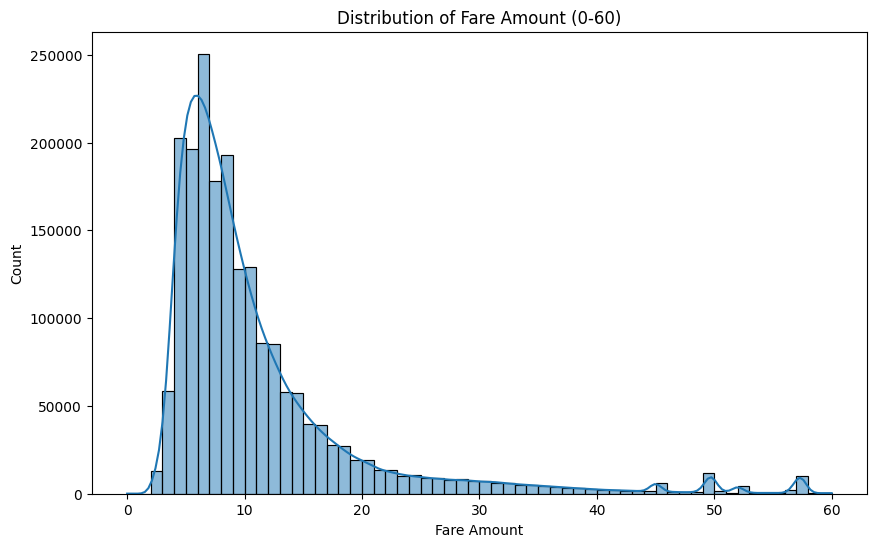

In [30]:
""" explore and plot the density plot of fare_amount """
# YOUR CODE HERE
dd_df_fare_limited = dd_df[dd_df["fare_amount"].between(0,60)]
plt.figure(figsize=(10,6))
sns.histplot(dd_df_fare_limited, x="fare_amount", bins=60, kde=True)
plt.title('Distribution of Fare Amount (0-60)')
plt.xlabel("Fare Amount")
plt.ylabel("Count")
plt.show()

### Inference : Majority is around 5 dollar and left skewed

#### Observe the number of workers and cores running in your machine

Initialize a client and observe how many workers are working and the number of cores utilizing for the given data set.

In [31]:
""" Initialize a client """
# YOUR CODE HERE
print_dask_workers()

Number of workers: 4
Number of cores (threads per worker * number of workers): 8


### EDA based on Time

#### Exercise 4: Extract day of the week (dow), hour, month and year from `pickup_datetime`. (1 Point)

**Hint:** use `pd.to_datetime()` function as dask does not have this functionality in it.

Remember to use `.compute()` while passing the dask dataframe in defined function.

In [28]:
%%time
start_time = time.time()
print("Extracting DOW, HOUR, MONTH and YEAR using Pandas Dataframe")
print("=====================================\n")
dd_df1 = dd_df.copy()

dd_df1["pickup_datetime"] = pd.to_datetime(dd_df1['pickup_datetime'])

# Extract day of the week (0=Monday, 6=Sunday)
dd_df1['day_of_week'] = dd_df1['pickup_datetime'].dt.dayofweek

#Day Name
dd_df1['day_name'] = dd_df1['pickup_datetime'].dt.day_name()

# Extract hour
dd_df1['hour'] = dd_df1['pickup_datetime'].dt.hour

# Extract month
dd_df1['month'] = dd_df1['pickup_datetime'].dt.month

# Extract year
dd_df1['year'] = dd_df1['pickup_datetime'].dt.year
pandas = time.time() - start_time
dd_df1.head()

Extracting DOW, HOUR, MONTH and YEAR using Pandas Dataframe

CPU times: user 30.2 s, sys: 982 ms, total: 31.2 s
Wall time: 32.4 s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_name,hour,month,year
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0,Monday,17,6,2009
0,91.0,2014-09-21 10:02:20+00:00,-74.009455,40.724818,-73.965932,40.638384,1,6,Sunday,10,9,2014
0,7.7,2009-05-29 18:58:00+00:00,-74.006425,40.744747,-73.981225,40.769387,3,4,Friday,18,5,2009
1,4.1,2010-08-23 14:09:16+00:00,-73.982811,40.766794,-73.982048,40.774986,1,0,Monday,14,8,2010
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,1,Tuesday,16,1,2010


In [29]:
%%time
start_time = time.time()
print("Extracting DOW, HOUR, MONTH and YEAR using DASK Dataframe")
print("=====================================\n")
print("Dataframe type before extraction: ", type(dd_df_dask))
print("=====================================\n")
dd_df_dask1 = dd_df_dask.copy()

dd_df_dask1["pickup_datetime"] = pd.to_datetime(dd_df_dask1['pickup_datetime'].compute())

# Extract day of the week (0=Monday, 6=Sunday)
dd_df_dask1['day_of_week'] = dd_df_dask1['pickup_datetime'].dt.dayofweek

#Day Name
dd_df_dask1['day_name'] = dd_df_dask1['pickup_datetime'].dt.day_name()

# Extract hour
dd_df_dask1['hour'] = dd_df_dask1['pickup_datetime'].dt.hour

# Extract month
dd_df_dask1['month'] = dd_df_dask1['pickup_datetime'].dt.month

# Extract year
dd_df_dask1['year'] = dd_df_dask1['pickup_datetime'].dt.year

print("Dataframe type after extraction: ", type(dd_df_dask1))
print("=====================================\n")
dask_time = time.time() - start_time
dd_df_dask1.head()

Extracting DOW, HOUR, MONTH and YEAR using DASK Dataframe

Dataframe type before extraction:  <class 'dask.dataframe.dask_expr._collection.DataFrame'>



Dataframe type after extraction:  <class 'dask.dataframe.dask_expr._collection.DataFrame'>



CPU times: user 34 s, sys: 2.62 s, total: 36.6 s
Wall time: 1min 14s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_name,hour,month,year
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0,Monday,17,6,2009
0,91.0,2014-09-21 10:02:20+00:00,-74.009455,40.724818,-73.965932,40.638384,1,6,Sunday,10,9,2014
0,7.7,2009-05-29 18:58:00+00:00,-74.006425,40.744747,-73.981225,40.769387,3,4,Friday,18,5,2009
1,4.1,2010-08-23 14:09:16+00:00,-73.982811,40.766794,-73.982048,40.774986,1,0,Monday,14,8,2010
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,1,Tuesday,16,1,2010


In [30]:
metrics_df.loc[len(metrics_df.index)] = ['Extracting datetime components', pandas_time, dask_time]
metrics_df

,Action,Pandas,Dask
0,CSV Read Time,5.833181,19.040558
1,After dropping rows with negative fare,NaN,9.284649
2,Dropping Duplicate Rows,2.666148,38.527332
3,Dropping Null/NA values,0.150854,65.505908
4,Extracting datetime components,0.150854,52.747204


In [31]:
print("Drop pickup_datetime from DASK dataframe")
print("=====================================\n")
dd_df_dask1 = dd_df_dask1.drop(columns=['pickup_datetime'], axis=1)
dd_df_dask1 = dd_df_dask1.compute()
print("Resulting dataframe type after dropping columns: ", type(dd_df_dask1))
dd_df_dask1 = dd.from_pandas(dd_df_dask1)
print("Resulting dataframe type after converting back to dask:", type(dd_df_dask1))
dd_df_dask1.head()

Drop pickup_datetime from DASK dataframe



Resulting dataframe type after dropping columns:  <class 'pandas.core.frame.DataFrame'>
Resulting dataframe type after converting back to dask: <class 'dask.dataframe.dask_expr._collection.DataFrame'>


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_name,hour,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,Monday,17,6,2009
0,91.0,-74.009455,40.724818,-73.965932,40.638384,1,6,Sunday,10,9,2014
0,7.7,-74.006425,40.744747,-73.981225,40.769387,3,4,Friday,18,5,2009
1,4.1,-73.982811,40.766794,-73.982048,40.774986,1,0,Monday,14,8,2010
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,1,Tuesday,16,1,2010


In [32]:
print("Drop pickup_datetime from PANDAS dataframe")
print("=====================================\n")
print("Resulting dataframe type before dropping columns: ", type(dd_df1))
print("=====================================\n")
dd_df1 = dd_df1.drop(columns=['pickup_datetime'], axis=1)
print("Resulting dataframe type after dropping columns: ", type(dd_df1))
print("=====================================\n")
dd_df1.head()

Drop pickup_datetime from PANDAS dataframe

Resulting dataframe type before dropping columns:  <class 'pandas.core.frame.DataFrame'>

Resulting dataframe type after dropping columns:  <class 'pandas.core.frame.DataFrame'>



,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_name,hour,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,Monday,17,6,2009
0,91.0,-74.009455,40.724818,-73.965932,40.638384,1,6,Sunday,10,9,2014
0,7.7,-74.006425,40.744747,-73.981225,40.769387,3,4,Friday,18,5,2009
1,4.1,-73.982811,40.766794,-73.982048,40.774986,1,0,Monday,14,8,2010
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,1,Tuesday,16,1,2010


##Inference from Exercise 4

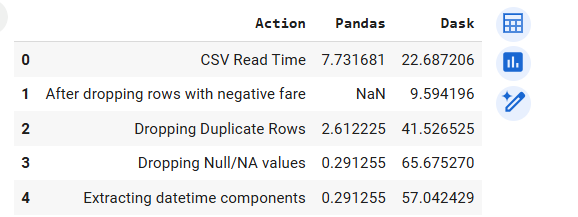

#### Exercise 5: a.) Plot the taxi trip by hour of the day  (0.5 Points)

* Partition the data into segments using `dask.from_pandas()`

* Plot the taxi trip for hour of the day. **Hint:** [sns.catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html)

<Figure size 1000x1500 with 0 Axes>

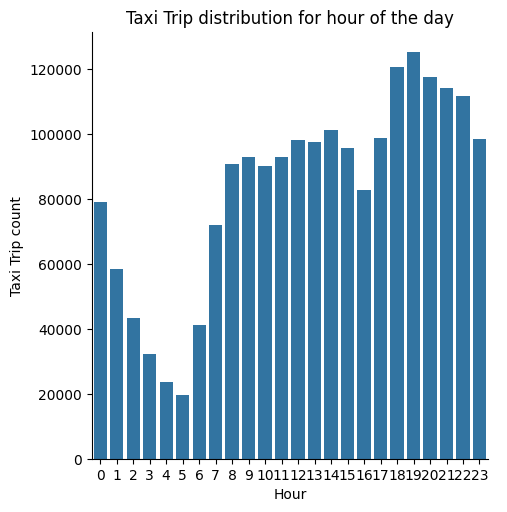

CPU times: user 4.87 s, sys: 382 ms, total: 5.25 s
Wall time: 5.52 s


In [37]:
%%time
""" taxi trip repartition by hour of the day """
# YOUR CODE HERE
plt.figure(figsize=(10,15))
sns.catplot(dd_df1, x="hour", kind="count")
plt.title('Taxi Trip distribution for hour of the day')
plt.xlabel("Hour")
plt.ylabel("Taxi Trip count")
plt.show()

<Figure size 1000x1500 with 0 Axes>

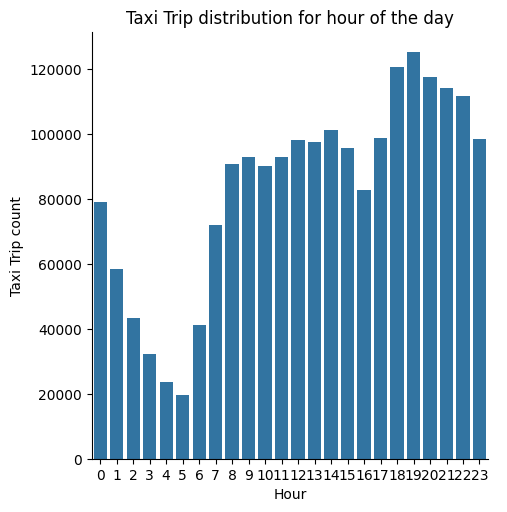

CPU times: user 6.89 s, sys: 1.3 s, total: 8.19 s
Wall time: 9.28 s


In [38]:
%%time
dd_df_dask_vis = dd.from_pandas(dd_df1, npartitions=10)
plt.figure(figsize=(10,15))
sns.catplot(data=dd_df_dask_vis.compute(), x="hour", kind="count")
plt.title('Taxi Trip distribution for hour of the day')
plt.xlabel("Hour")
plt.ylabel("Taxi Trip count")
plt.show()

#### Exercise 5: b.) Plot the taxi trip repartition by day of the week (dow) (0.5 Points)

<Figure size 1000x1500 with 0 Axes>

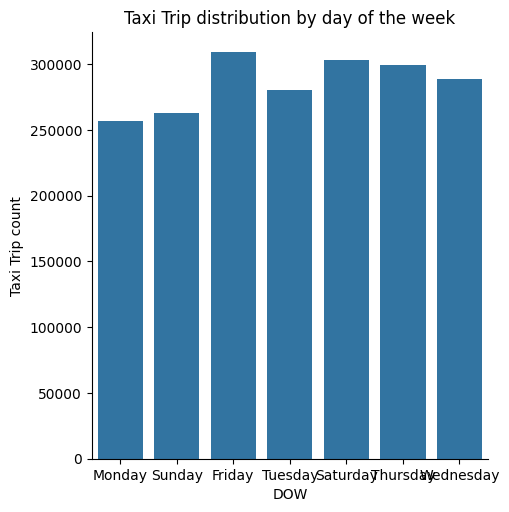

CPU times: user 7.91 s, sys: 2.24 s, total: 10.1 s
Wall time: 11.4 s


In [39]:
%%time
""" taxi trip repartition by day of the week """
# YOUR CODE HERE
dd_df_dask_vis = dd.from_pandas(dd_df1, npartitions=10)
plt.figure(figsize=(10,15))
sns.catplot(data=dd_df_dask_vis.compute(), x="day_name", kind="count")
plt.title('Taxi Trip distribution by day of the week')
plt.xlabel("DOW")
plt.ylabel("Taxi Trip count")
plt.show()

<Figure size 1000x1500 with 0 Axes>

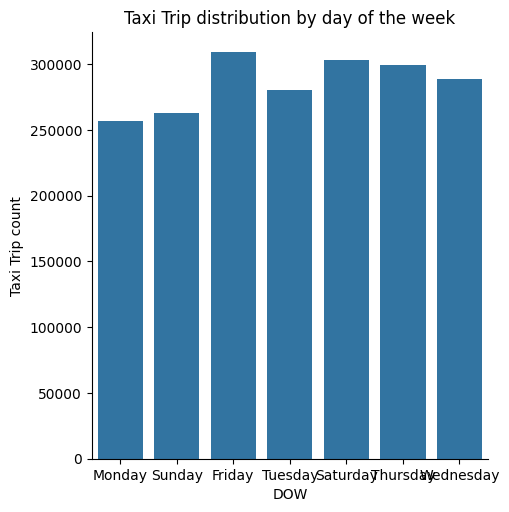

CPU times: user 5.99 s, sys: 300 ms, total: 6.29 s
Wall time: 6.82 s


In [40]:
%%time
# YOUR CODE HERE
plt.figure(figsize=(10,15))
sns.catplot(dd_df1, x="day_name", kind="count")
plt.title('Taxi Trip distribution by day of the week')
plt.xlabel("DOW")
plt.ylabel("Taxi Trip count")
plt.show()

#### Exercise 6: a.) Draw a plot between the target variable and passenger count and analyze it.  (0.5 Points)

In [41]:
fare_passenger_df = dd_df1.groupby(['passenger_count']).agg({'fare_amount': ['mean', 'sum', 'count', 'min', 'max']})
fare_passenger_df

fare_amount                                      
                       mean          sum    count    min      max
passenger_count                                                  
0                  8.862578     63004.07     7109    2.5    90.00
1                 11.225602  15526522.73  1383135    0.0  1273.31
2                 11.820330   3497304.70   295872    0.0   263.25
3                 11.534860   1011007.40    87648    2.5   290.25
4                 11.748537    501098.59    42652    0.0   211.44
5                 11.209709   1586028.04   141487    0.0   128.61
6                 12.159071    510693.15    42001    2.5   126.33
9                104.000000       104.00        1  104.0   104.00
208                3.300000         3.30        1    3.3     3.30

In [42]:
dd_df1[dd_df1['passenger_count']==208]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_name,hour,month,year
258837,3.3,0.0,0.0,0.0,0.0,208,3,Thursday,11,7,2009


In [43]:
dd_df1[dd_df1['passenger_count']==1]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_name,hour,month,year
0,4.50,-73.844311,40.721319,-73.841610,40.712278,1,0,Monday,17,6,2009
0,91.00,-74.009455,40.724818,-73.965932,40.638384,1,6,Sunday,10,9,2014
1,4.10,-73.982811,40.766794,-73.982048,40.774986,1,0,Monday,14,8,2010
1,16.90,-74.016048,40.711303,-73.979268,40.782004,1,1,Tuesday,16,1,2010
1,5.00,-73.942057,40.817467,-73.940715,40.824472,1,4,Friday,2,10,2012
...,...,...,...,...,...,...,...,...,...,...,...
670180,3.50,-73.972488,40.754936,-73.967842,40.756126,1,5,Saturday,12,2,2015
670181,10.50,-73.948498,40.782492,-73.963142,40.810860,1,4,Friday,8,3,2012
670182,9.50,-73.994058,40.719994,-73.965066,40.710425,1,5,Saturday,0,10,2013
670183,12.00,-73.983570,40.766350,-73.999687,40.748893,1,4,Friday,19,11,2013


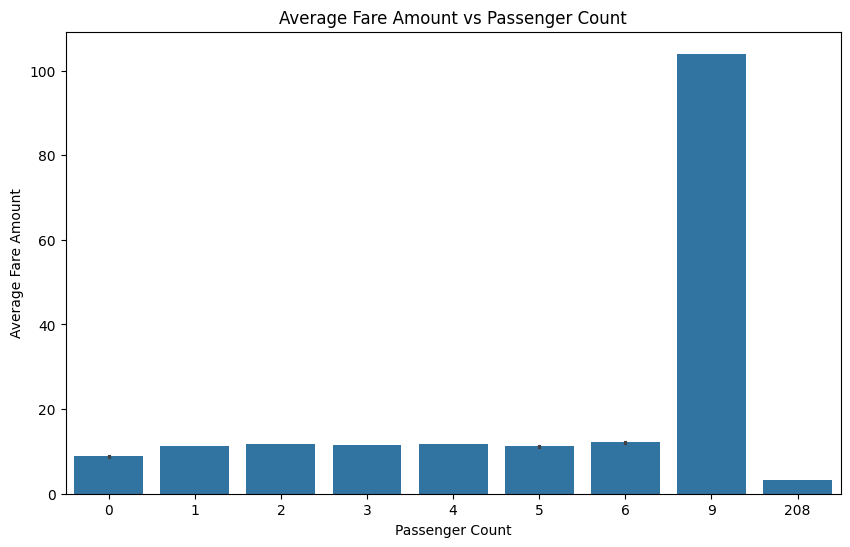

CPU times: user 46.6 s, sys: 2.54 s, total: 49.2 s
Wall time: 48.3 s


In [44]:
%%time
""" passenger count feature """
# YOUR CODE HERE
plt.figure(figsize=(10,6))
dd_df_dask_vis = dd.from_pandas(dd_df1, npartitions=10)
sns.barplot(data=dd_df_dask_vis.compute(), x="passenger_count", y="fare_amount")
plt.title('Average Fare Amount vs Passenger Count')
plt.xlabel("Passenger Count")
plt.ylabel("Average Fare Amount")
plt.show()

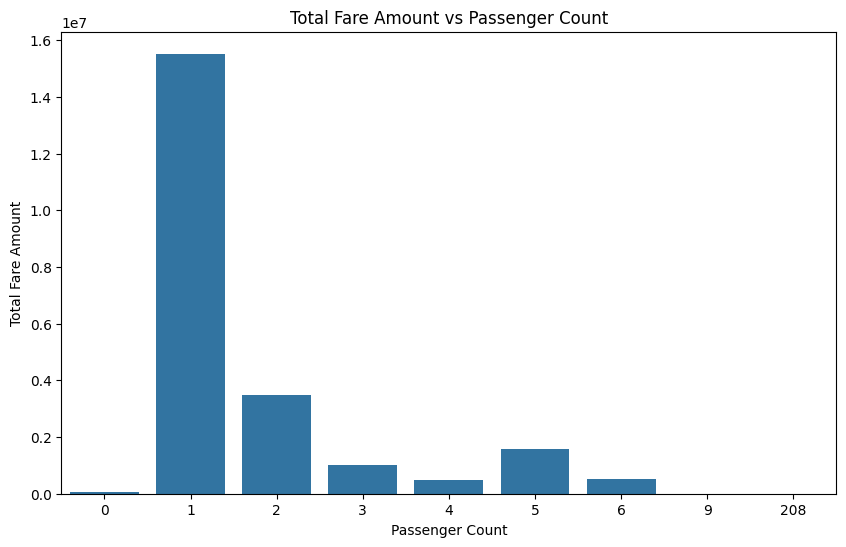

CPU times: user 1.81 s, sys: 293 ms, total: 2.1 s
Wall time: 2.66 s


In [45]:
%%time
# 1. Group by passenger_count and sum fare_amount
fare_by_passenger = dd_df_dask1.groupby('passenger_count')['fare_amount'].sum()

# 2. Convert to Pandas DataFrame
fare_by_passenger_pandas = fare_by_passenger.compute().reset_index()

# 3. Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='passenger_count', y='fare_amount', data=fare_by_passenger_pandas)
plt.title('Total Fare Amount vs Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Total Fare Amount')
plt.show()

#### Exercise 6: b.) Draw a plot between the target variable and hour and analyze it. (0.5 Points)

In [46]:
fare_hour_df = dd_df1.groupby(['hour']).agg({'fare_amount': ['mean', 'sum', 'count', 'min', 'max']})
fare_hour_df

fare_amount                                   
            mean         sum   count   min      max
hour                                               
0      11.711967   926920.19   79143  0.00   488.00
1      11.471889   670176.30   58419  0.00   204.00
2      11.503893   500131.73   43475  0.00   225.00
3      11.950853   385092.34   32223  0.00   250.00
4      13.445704   316081.62   23508  2.50   200.00
5      15.215968   299876.30   19708  0.00   400.00
6      12.247187   506396.70   41348  0.00   208.00
7      10.937484   788756.64   72115  0.00   258.00
8      10.899521   990777.34   90901  0.00   400.00
9      10.865873  1011688.87   93107  0.00   500.00
10     10.888296   982374.73   90223  0.01   263.25
11     11.151678  1037016.80   92992  0.00   262.04
12     11.172908  1098810.80   98346  0.00   250.25
13     11.587566  1130668.33   97576  0.08   495.00
14     11.883635  1203122.94  101242  0.00   450.00
15     12.012665  1151137.65   95827  0.00  1273.31
16     11.879478   983929.66   82826  0.00   450.00
17     11.444374  1130383.75   98772  0.01   347.54
18     10.915367  1318576.35  120800  0.00   195.33
19     10.594848  1326750.45  125226  0.00   217.00
20     10.804565  1270616.80  117600  0.00   255.00
21     11.009544  1257554.14  114224  0.00   236.00
22     11.308697  1262785.61  111665  0.00   223.25
23     11.619424  1146139.94   98640  0.00   325.00

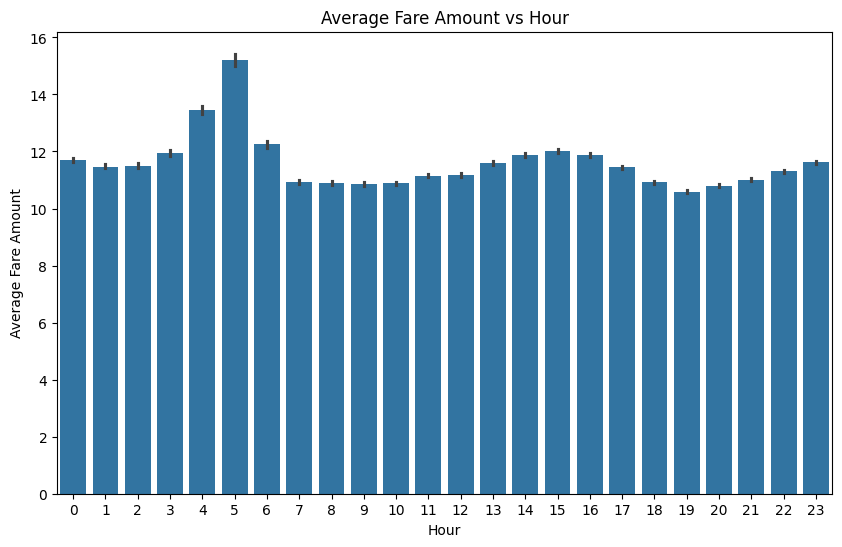

In [47]:
""" fare amount by hour """
# YOUR CODE HERE
plt.figure(figsize=(10,6))
dd_df_dask_vis = dd.from_pandas(dd_df1, npartitions=10)
sns.barplot(data=dd_df_dask_vis.compute(), x="hour", y="fare_amount")
plt.title('Average Fare Amount vs Hour')
plt.xlabel("Hour")
plt.ylabel("Average Fare Amount")
plt.show()

### Feature Engineering

#### Exercise 7: Compute the Haversine distance between pickup and dropoff point. (1 Point)

* Convert the latitude and longitude co-rodinates to radians

* Calculate the Haversine distance

  **Hint:** [haversine_distances](https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4)

* Add the "distance" feature to the dataset and plot its distribution

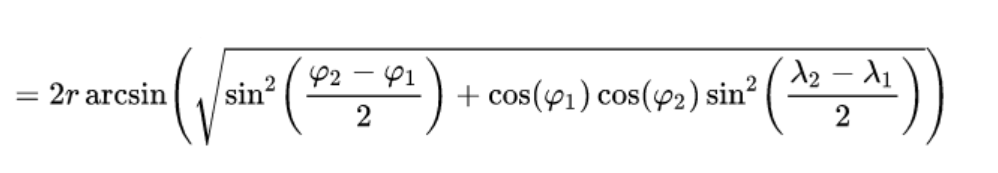

In [33]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [34]:
dd_df_dask1.head(2)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_name,hour,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,Monday,17,6,2009
0,91.0,-74.009455,40.724818,-73.965932,40.638384,1,6,Sunday,10,9,2014


In [35]:
""" distance feature """
# YOUR CODE HERE
distances_km = []

dd_df_dask1['distance'] = dd_df_dask1.apply(
    lambda row: haversine_distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude),
    axis=1,
    meta=('distance', float) # Specify the output column name and dtype
)
dd_df_dask1.head(2)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_name,hour,month,year,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,Monday,17,6,2009,1.03
0,91.0,-74.009455,40.724818,-73.965932,40.638384,1,6,Sunday,10,9,2014,10.29


In [36]:
dd_df_dask1.head(2)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_name,hour,month,year,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,Monday,17,6,2009,1.03
0,91.0,-74.009455,40.724818,-73.965932,40.638384,1,6,Sunday,10,9,2014,10.29


In [37]:
dd_df_dask1[dd_df_dask1['distance']<50].compute()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_name,hour,month,year,distance
0,4.50,-73.844311,40.721319,-73.841610,40.712278,1,0,Monday,17,6,2009,1.03
0,91.00,-74.009455,40.724818,-73.965932,40.638384,1,6,Sunday,10,9,2014,10.29
0,7.70,-74.006425,40.744747,-73.981225,40.769387,3,4,Friday,18,5,2009,3.47
1,4.10,-73.982811,40.766794,-73.982048,40.774986,1,0,Monday,14,8,2010,0.91
1,16.90,-74.016048,40.711303,-73.979268,40.782004,1,1,Tuesday,16,1,2010,8.45
...,...,...,...,...,...,...,...,...,...,...,...,...
670180,3.50,-73.972488,40.754936,-73.967842,40.756126,1,5,Saturday,12,2,2015,0.41
670181,10.50,-73.948498,40.782492,-73.963142,40.810860,1,4,Friday,8,3,2012,3.39
670182,9.50,-73.994058,40.719994,-73.965066,40.710425,1,5,Saturday,0,10,2013,2.67
670183,12.00,-73.983570,40.766350,-73.999687,40.748893,1,4,Friday,19,11,2013,2.37


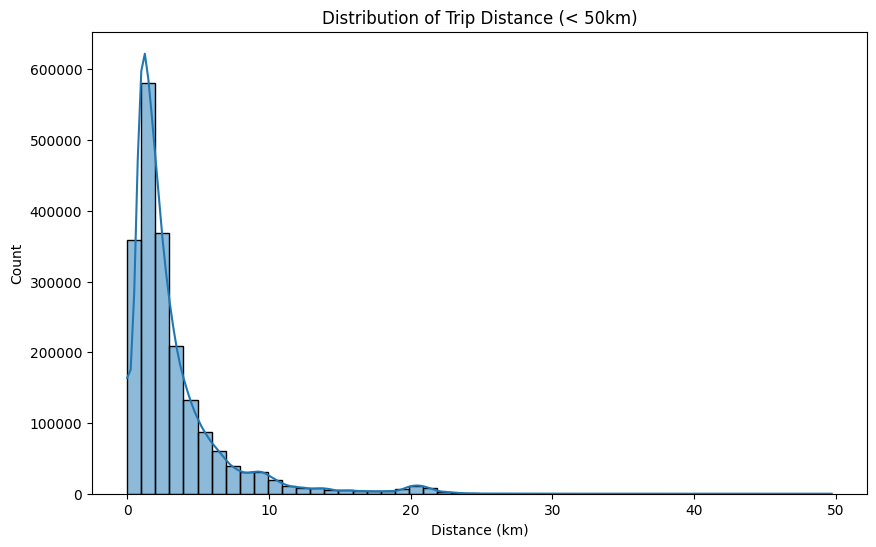

In [53]:
""" plot the distance feature (take distance < 50) """
# YOUR CODE HERE
plt.figure(figsize=(10, 6))
sns.histplot(data=dd_df_dask1[dd_df_dask1['distance']<50].compute(), x="distance", bins=50, kde=True)
plt.title('Distribution of Trip Distance (< 50km)')
plt.xlabel("Distance (km)")
plt.ylabel("Count")
plt.show()

### Show the plot between distance and fare amount

**Hint:** [sns.scatterplot()](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)

In [54]:
df = dd_df_dask1.groupby(['distance']).agg({'fare_amount': ['mean', 'sum', 'count', 'min', 'max']}).compute()
df

fare_amount                             
                mean       sum count   min    max
distance                                         
1.03        5.803697  37253.93  6419   2.5  65.00
10.29      30.339763   7675.96   253   4.1  91.00
3.47       11.306050  23787.93  2104   2.5  64.00
0.91        5.474240  33540.67  6127   2.5  57.33
8.45       23.608910   6279.97   266   3.7  56.50
...              ...       ...   ...   ...    ...
29.83      65.000000     65.00     1  65.0  65.00
3198.94     4.900000      4.90     1   4.9   4.90
99.08      10.100000     10.10     1  10.1  10.10
5290.91     7.300000      7.30     1   7.3   7.30
4523.85     8.500000      8.50     1   8.5   8.50

[5499 rows x 5 columns]

INFO:distributed.core:Event loop was unresponsive in Nanny for 5.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 5.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

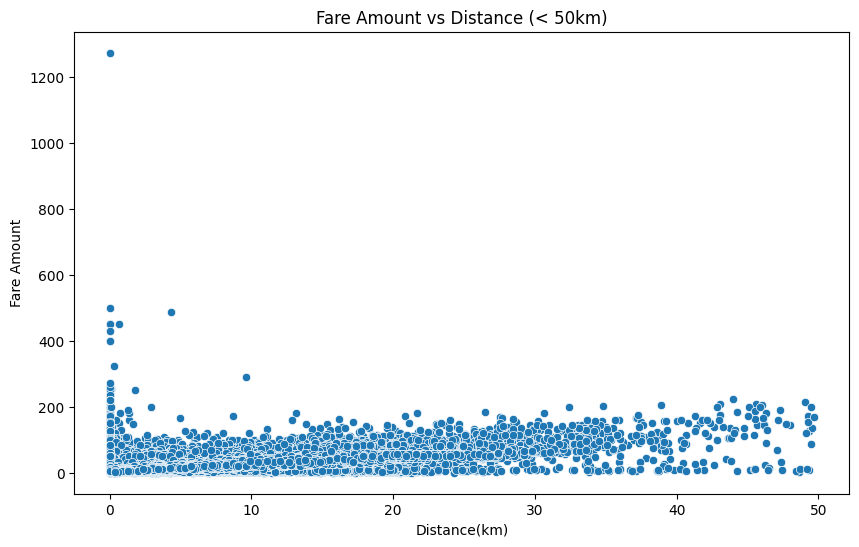

In [55]:
""" correlation between fare_amount and distance """
# YOUR CODE HERE
plt.figure(figsize=(10,6))
sns.scatterplot(data=dd_df_dask1[dd_df_dask1['distance'] < 50].compute(), x="distance", y="fare_amount")
plt.title('Fare Amount vs Distance (< 50km)')
plt.xlabel("Distance(km)")
plt.ylabel("Fare Amount")
plt.show()

### Preparing dataset for model implementation

**Note:** Use the above modified dataset for modelling.

In [56]:
def correlation_map(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    df_heatmap = df.compute().copy()
    df_heatmap = df_heatmap.apply(pd.to_numeric, errors='coerce')
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_heatmap.corr(),
                annot=True,
                linewidth=0.5,
                center=0,
                cmap='rainbow',
                fmt='.2f')
    plt.show()

INFO:distributed.core:Event loop was unresponsive in Nanny for 3.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause tim

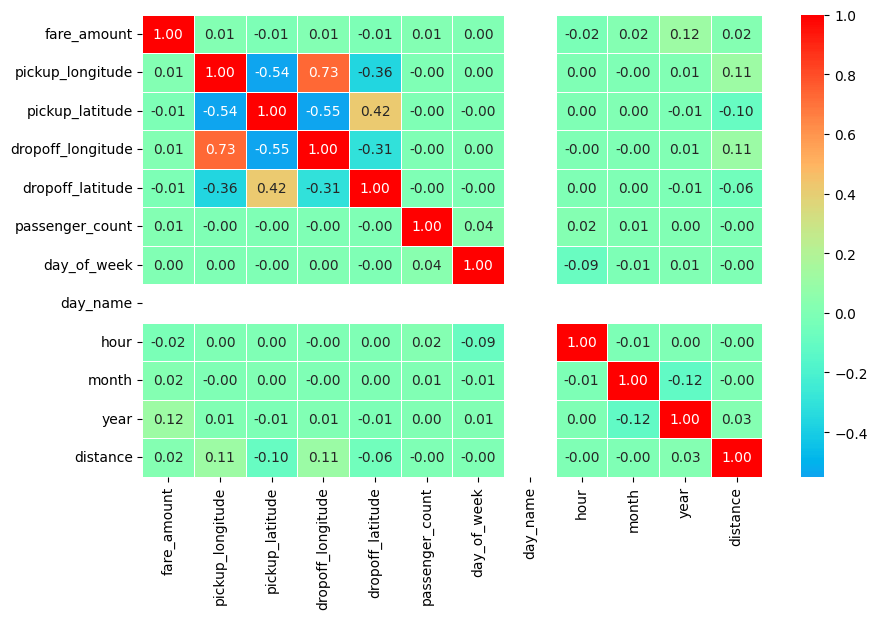

In [57]:
correlation_map(dd_df_dask1)

In [40]:
# YOUR CODE HERE
features = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'day_of_week','hour', 'month', 'year', 'distance']
target = ['fare_amount']

### Removing outliers from training set Based on Coordinates

#### Exercise 8: Remove the outliers using the given latitude and longitude features from the dataset. We need to analyze the data of taxi within New York City. (1 Point)

**Hint:** Given the co-ordinates of New York city are Latitude: 40.7128° and Longitude: -74.0060°. You can include the pickup and drop off points such that there left and right value mean will be the given co-ordinate value.

Also, choose nearest extreme values.

Use `.between()` and pass left and right value attributes accordingly.

In [38]:
""" remove the outliers in pickup latitude longitude and drop off latitude and longitude """
# YOUR CODE HERE
print("Removing outliers based on location")
print("=====================================\n")

nyc_latitude = 40.7128
nyc_longitude = -74.0060

# Define the range based on the mean coordinates of NYC
lat_range = [nyc_latitude - 1, nyc_latitude + 1]
lon_range = [nyc_longitude - 1, nyc_longitude + 1]

# Remove outliers based on pickup and dropoff coordinates
dd_df_dask_cleaned = dd_df_dask1[
    (dd_df_dask1['pickup_latitude'].between(lat_range[0], lat_range[1])) &
    (dd_df_dask1['dropoff_latitude'].between(lat_range[0], lat_range[1])) &
    (dd_df_dask1['pickup_longitude'].between(lon_range[0], lon_range[1])) &
    (dd_df_dask1['dropoff_longitude'].between(lon_range[0], lon_range[1]))
]

print(f"Number of rows before outlier removal: {len(dd_df_dask1)}")
print(f"Number of rows after outlier removal: {len(dd_df_dask_cleaned)}")


Removing outliers based on location

Number of rows before outlier removal: 1999906


INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Number of rows after outlier removal: 1958236


### Modelling

#### Exercise 9: Divide the data into train and test splits with X as feature variables and y as target variable  (1 Point)

* Divide data into train test split with 70-30 ratio, Hint: `train_test_split()`

* As dask functions operate lazily so, before calling `.fit()` function, call the dask dataframe with `.compute()`.
* Convert X_train and y_train into array using `.values` as [dask's](https://ml.dask.org/modules/api.html) `.fit()` function takes array as attribute

In [41]:
#Try using python
# YOUR CODE HERE
start_time = time.time()
from dask_ml.model_selection import train_test_split
X = dd_df_dask_cleaned[features].compute()
y = dd_df_dask_cleaned[target].compute()
python_time = time.time() - start_time

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

In [42]:
print("Type of X: ", type(X))
print("Type of y: ", type(y))

Type of X:  <class 'pandas.core.frame.DataFrame'>
Type of y:  <class 'pandas.core.frame.DataFrame'>


In [52]:
python_time

187.2735152244568

In [53]:
start_time = time.time()
""" select the target and feature variables and split the data into train and test """
# YOUR CODE HERE
from dask_ml.model_selection import train_test_split
X = dd_df_dask_cleaned[features].to_dask_array(lengths=True)
y = dd_df_dask_cleaned[target].to_dask_array(lengths=True)

X_chunk = X.rechunk(chunks=(1000, -1)) # Rechunk to have chunks of 10000 rows and all columns
y_chunk = y.rechunk(chunks=(1000, -1))
dask_time = time.time() - start_time
X_chunk

INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-914289' coro=<Client._gather.<locals>.wait() done, defined at /usr/local/lib/python3.11/dist-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/distributed/client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [45]:
metrics_df.loc[len(metrics_df.index)] = ['Creating feature and target variables', python_time, dask_time]

In [46]:
metrics_df

,Action,Pandas,Dask
0,CSV Read Time,5.833181,19.040558
1,After dropping rows with negative fare,NaN,9.284649
2,Dropping Duplicate Rows,2.666148,38.527332
3,Dropping Null/NA values,0.150854,65.505908
4,Extracting datetime components,0.150854,52.747204
5,Creating feature and target variables,187.273515,169.302922


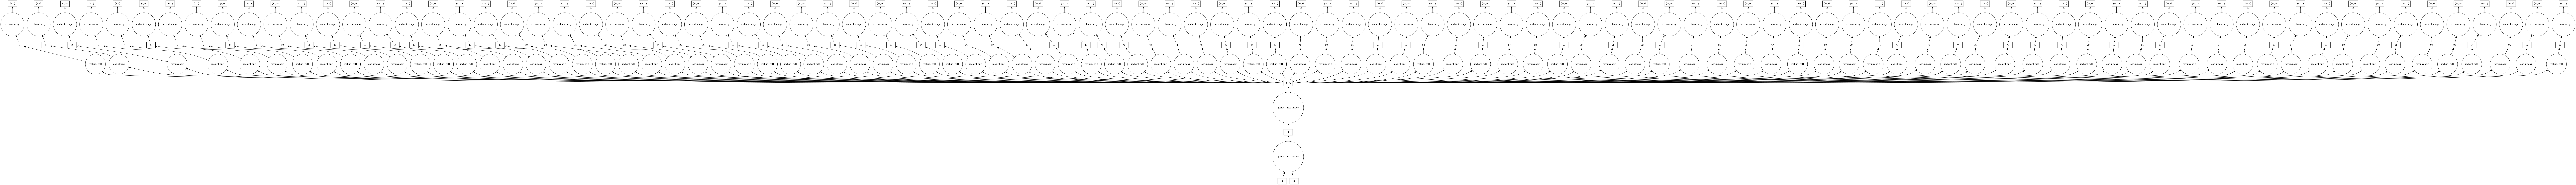

In [48]:
X_chunk.visualize()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_chunk, y_chunk)
X_train

dask.array<concatenate, shape=(1762412, 10), dtype=float64, chunksize=(18000, 10), chunktype=numpy.ndarray>

In [ ]:
# prompt: fitting linear regression using X_chunk

%%time
""" fit the linear regression model using X_chunk and y_chunk """
# YOUR CODE HERE
start_time = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
dask_time = time.time() - start_time
print(f"Model fitting time with Dask: {dask_time:.2f} seconds")

start_time = time.time()
lr_pandas = LinearRegression()
lr_pandas.fit(X.values, y.values)
python_time = time.time() - start_time
print(f"Model fitting time with Pandas: {python_time:.2f} seconds")

metrics_df.loc[len(metrics_df.index)] = ['Linear Regression Model Fitting', python_time, dask_time]
metrics_df



In [51]:
print("Fitting the model")
print("-------------------------------------")
start_time = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
dask_time = time.time() - start_time
print(f"Model fitting time with Dask: {dask_time:.2f} seconds")

Fitting the model
-------------------------------------


INFO:distributed.nanny:Closing Nanny gracefully at 'tcp://127.0.0.1:38365'. Reason: worker-close
INFO:distributed.nanny:Closing Nanny gracefully at 'tcp://127.0.0.1:41591'. Reason: worker-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:51140; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:34921 name: 1 (stimulus_id='handle-worker-cleanup-1748084463.1388686')
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:51148; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:43383 name: 0 (stimulus_id='handle-worker-cleanup-1748084463.1477244')
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-855112' coro=<Client._gather.<locals>.wait() done, defined at /usr/local/lib/python3.11/dist-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/distributed/client.py", line 2386, in wait
    raise Al

KeyboardInterrupt: 

INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:43919 name: 2 (stimulus_id='handle-worker-cleanup-1748084463.2314298')


#### Exercise 10: Predict the test data and calculate the mean squared error and r2 score. (1 Point)

**Hint:** Remember to call `.compute()` function as dask functions operate lazily and convert the dask dataframe to `.values` (Array type) as suggested in above exercise

In [ ]:
""" predict the values """
# YOUR CODE HERE
# predict on test data
pred = lr.predict(X_test)

# Convert to NumPy arrays and handle NaNs
y_test_np = y_test.compute()
pred_np = pred.compute()

In [ ]:
""" compute mean squared error and r2_score """
# YOUR CODE HERE

score = r2_score(y_test_np, pred_np)
mse = mean_squared_error(y_test_np, pred_np)
print("Root mean squared error: ", np.sqrt(mse))
print("R2 Score: ", score)

### Report Analysis
* Discuss the pros and cons of using dask
* Derive the insights and discuss
* Comment on the performance metrics (MSE, $R^2$ score)
